# 4. 【応用編】　ホワイトノイズから分散不均一構造へ -ARCH，GARCHモデルの活用-

## 4-1. 自己回帰モデルの当てはめ残差を調べる

今，ARモデルが正しいとする．以下の例では，AR(1)を考えている．すると，実現値とモデルの間の誤差，すなわち当てはめ誤差は，$\epsilon_t$(ホワイトノイズ)を表していることになる(正確にはホワイノイズの差分？)．

### 残差系列を調べる

自己回帰モデルの残差がホワイトノイズになっているかどうかで，モデルの信頼度を評価することができる．これはすなわち，残差に時間依存の関係がないことを調べるということである．これを確認するには以下の方法がある．

+ 残差に自己相関がないか確認する(コレログラムを描いて定性的に確認できる)
+ ARモデルを当てはめても次数0が選択される．
+ Ljung-Box検定のような自己相関の検定を使用する．

### 誤差分散(残差の2乗系列を調べる)

残差の2乗に対しても，時間的構造は見られないはずである．

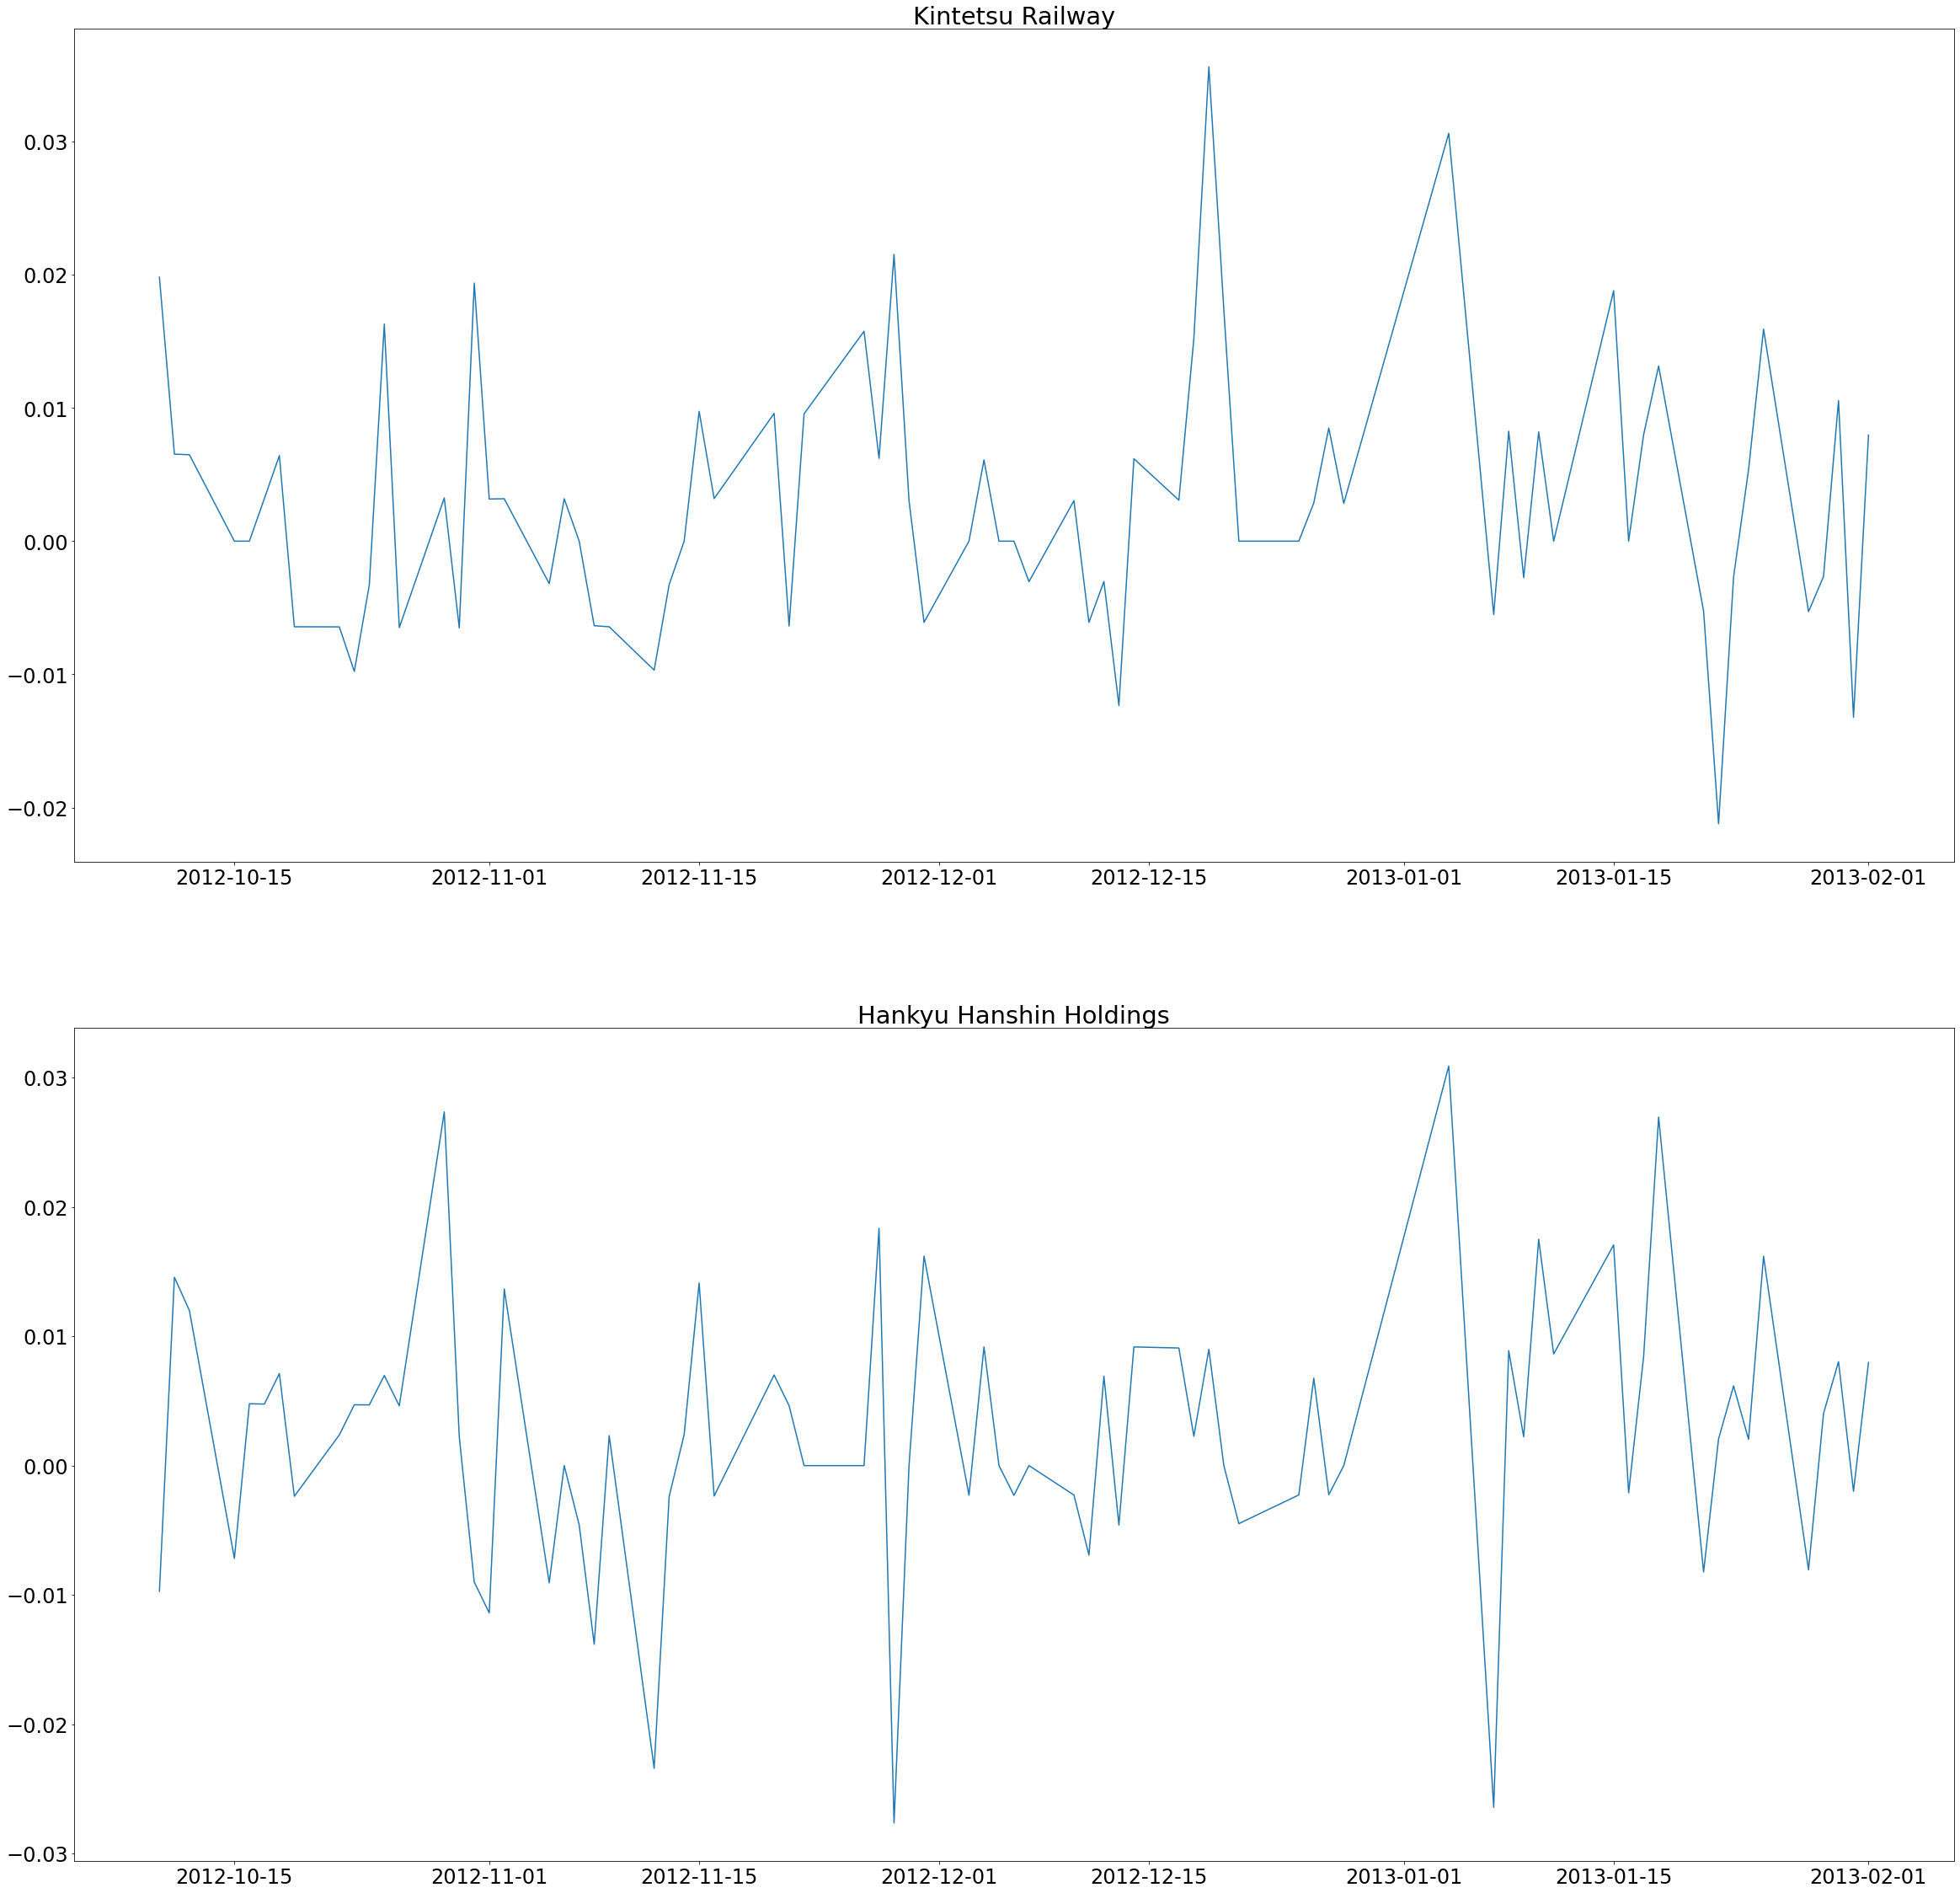

In [56]:
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import statsmodels.api as sm

plt.rcParams["font.size"] = 24
start = datetime.date(2012, 10, 6)
end = start + datetime.timedelta(days=120)
stocks = [
    {'code':'9041.JP', 'company':'Kintetsu Railway'},
    {'code':'9042.JP', 'company':'Hankyu Hanshin Holdings'}
]
fig = plt.figure(figsize=(40,40))

for i, s in enumerate(stocks):
    df = pdr.data.DataReader(stocks[i]['code'], 'stooq', start, end).iloc[::-1]
    stocks[i]['data'] = df

for i, s in enumerate(stocks):
    ax = fig.add_subplot(2,1,i+1)
    df = pdr.data.DataReader(s['code'], 'stooq', start, end).iloc[::-1]
    s['data']['log'] = np.log(stocks[i]['data']['Close'])
    # 対数差収益率
    s['data']['log_return'] = s['data']['log'].diff().dropna()
    s['data'].dropna(inplace=True)
    ax.plot(s['data']['log_return'])
    ax.set_title(s["company"])

In [57]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
for i, s in enumerate(stocks):
    print(s['company'])
    model = ar_select_order(np.array(s['data']['log_return']), maxlag=20).model
    res = model.fit()
    s['res'] = res
    print(res.summary())

Kintetsu Railway
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   75
Model:                     AutoReg(0)   Log Likelihood                 240.914
Method:               Conditional MLE   S.D. of innovations              0.010
Date:                Sun, 10 Apr 2022   AIC                           -477.828
Time:                        11:32:25   BIC                           -473.193
Sample:                             0   HQIC                          -475.977
                                   75                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      2.770      0.006       0.001       0.005
Hankyu Hanshin Holdings
                            AutoReg Model Results                             
Dep. Variab

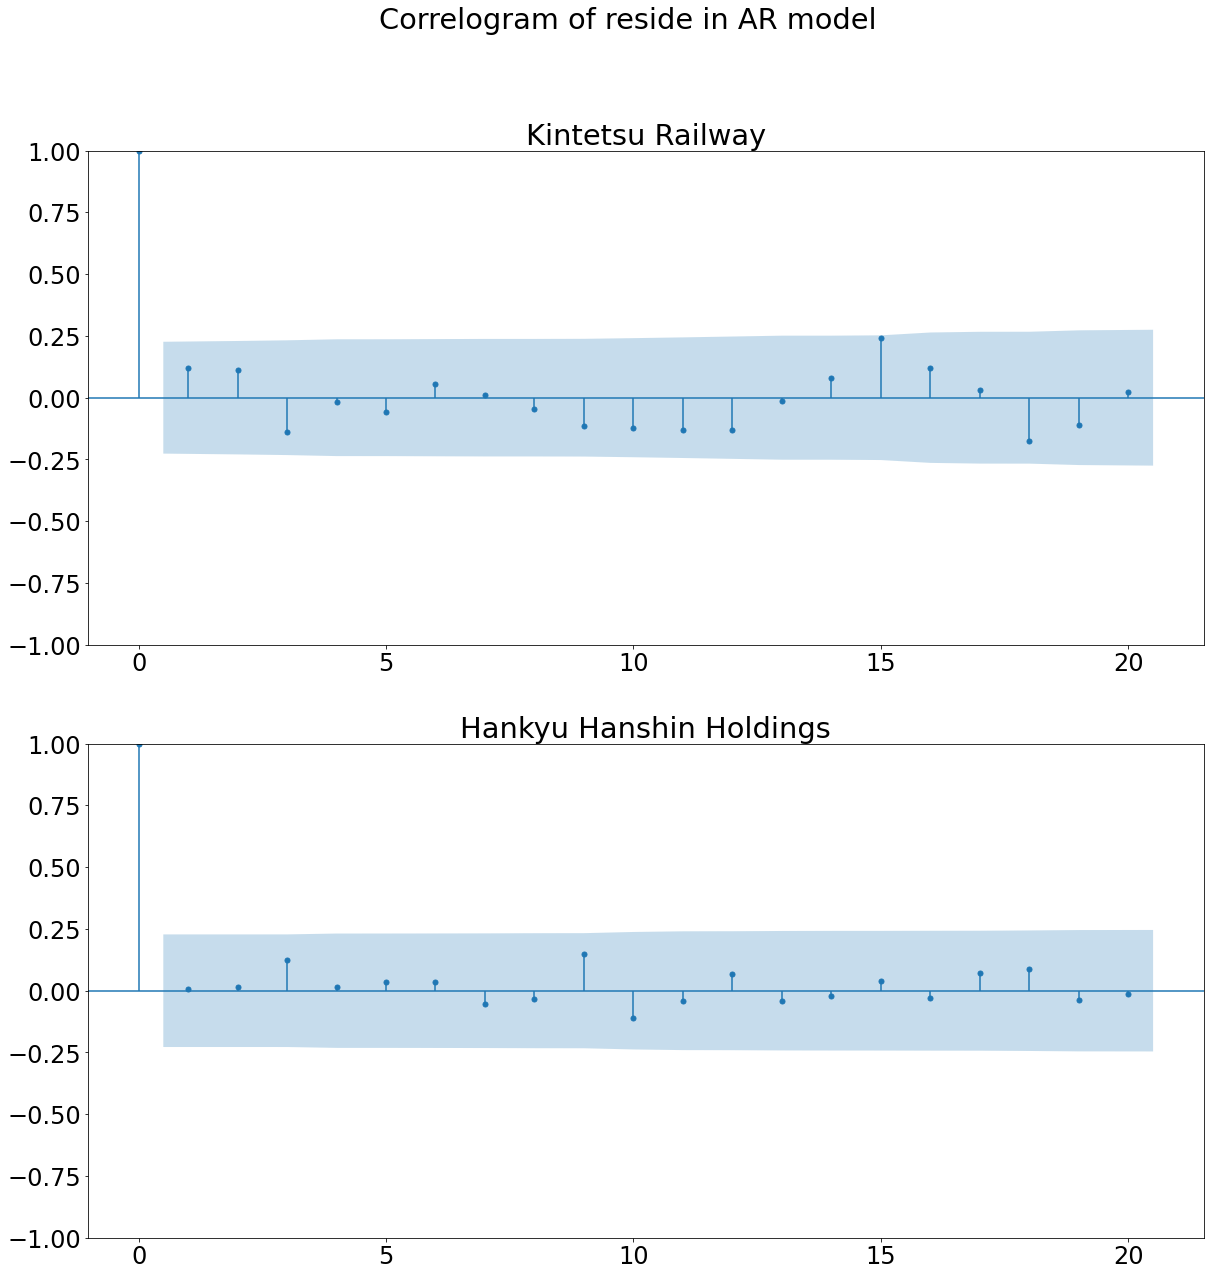

In [58]:
fig = plt.figure(figsize=(20, 20))
fig.suptitle('Correlogram of reside in AR model')
for i, s in enumerate(stocks):
    ax = fig.add_subplot(2,1,i+1)
    sm.graphics.tsa.plot_acf(s['res'].resid, lags=20, ax=ax)
    ax.set_title(s['company'])

In [59]:
# 残差のARモデル
for i, s in enumerate(stocks):
    print(s['company'])
    model = ar_select_order(np.array(s['res'].resid), maxlag=20).model
    res = model.fit()
    print(res.summary())

Kintetsu Railway
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   75
Model:                     AutoReg(0)   Log Likelihood                 240.914
Method:               Conditional MLE   S.D. of innovations              0.010
Date:                Sun, 10 Apr 2022   AIC                           -477.828
Time:                        11:32:25   BIC                           -473.193
Sample:                             0   HQIC                          -475.977
                                   75                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.253e-19      0.001   2.89e-16      1.000      -0.002       0.002
Hankyu Hanshin Holdings
                            AutoReg Model Results                             
Dep. Variab

In [62]:
from statsmodels.stats.diagnostic import acorr_ljungbox

for i, s in enumerate(stocks):
    print("{}\n{}".format(s['company'], acorr_ljungbox(s['res'].resid)))

Kintetsu Railway
     lb_stat  lb_pvalue
1   1.108527   0.292402
2   2.082321   0.353045
3   3.594160   0.308754
4   3.617735   0.460204
5   3.898633   0.564101
6   4.155181   0.655685
7   4.165791   0.760496
8   4.332071   0.825989
9   5.441045   0.794293
10  6.750773   0.748745
Hankyu Hanshin Holdings
     lb_stat  lb_pvalue
1   0.003713   0.951411
2   0.026177   0.986997
3   1.242208   0.742900
4   1.262718   0.867668
5   1.364529   0.928154
6   1.477437   0.960979
7   1.735716   0.973012
8   1.820514   0.986029
9   3.703667   0.929812
10  4.786588   0.904971


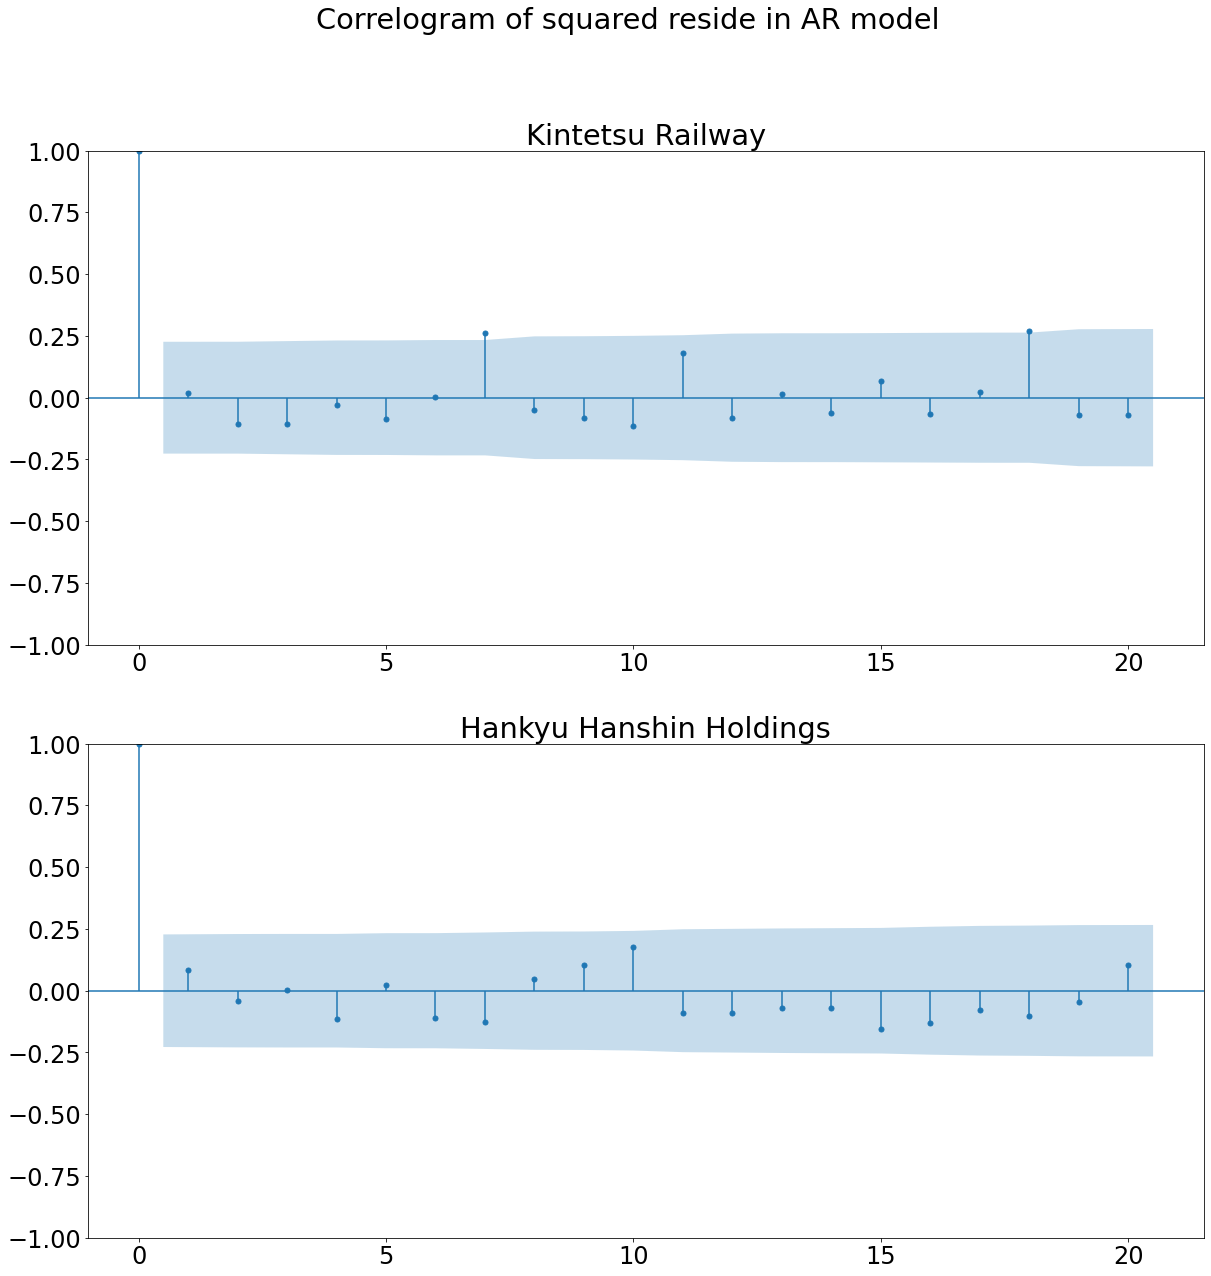

In [61]:
fig = plt.figure(figsize=(20, 20))
fig.suptitle('Correlogram of squared reside in AR model')
for i, s in enumerate(stocks):
    ax = fig.add_subplot(2,1,i+1)
    sm.graphics.tsa.plot_acf(s['res'].resid**2, lags=20, ax=ax)
    ax.set_title(s['company'])

In [63]:
for i, s in enumerate(stocks):
    print("{}\n{}".format(s['company'], acorr_ljungbox(s['res'].resid**2)))

Kintetsu Railway
      lb_stat  lb_pvalue
1    0.023424   0.878360
2    0.947577   0.622639
3    1.888079   0.595958
4    1.959973   0.743121
5    2.562074   0.767119
6    2.563518   0.861292
7    8.473403   0.292704
8    8.700313   0.368204
9    9.318238   0.408432
10  10.486672   0.398881
Hankyu Hanshin Holdings
     lb_stat  lb_pvalue
1   0.535796   0.464180
2   0.660394   0.718782
3   0.660526   0.882447
4   1.748690   0.781855
5   1.797833   0.876351
6   2.828877   0.829998
7   4.171523   0.759823
8   4.377473   0.821563
9   5.321426   0.805437
10  8.071514   0.621852


In [64]:
# 残差の2乗のARモデル
for i, s in enumerate(stocks):
    print(s['company'])
    model = ar_select_order(np.array(s['res'].resid**2), maxlag=20).model
    res = model.fit()
    print(res.summary())

Kintetsu Railway
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   75
Model:                     AutoReg(0)   Log Likelihood                 545.141
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Sun, 10 Apr 2022   AIC                          -1086.281
Time:                        11:34:21   BIC                          -1081.646
Sample:                             0   HQIC                         -1084.430
                                   75                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.494e-05   1.95e-05      4.874      0.000    5.68e-05       0.000
Hankyu Hanshin Holdings
                            AutoReg Model Results                             
Dep. Variab

### 結果のまとめ

近鉄のデータは，元々AR(0)であり，残差や残差の2乗のコレログラムからも，これがARモデルを満たさないことがわかる．

一方で，阪急のデータではAR(1)となり，残差や残差の2乗のコレログラム，検定からもARモデルを満たしていそうだということがわかる．

## 4-2. ARCHモデルとGARCHモデル

